# IMEX-RB: A Fast and Stable Time Integration Method


In [14]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../utils'))

In [15]:
import numpy as np
import scipy
from imexrb import imexrb
from euler import backward_euler, forward_euler
import mpl_pubstyle
from errors import compute_errors
from helpers import *

## Solving a 2D Advection Diffusion Equation

The advection–diffusion problem is defined over the spatial domain $\Omega = [0,2] \times [0,2]$ and the time interval $[0,1]$:

$$
\begin{cases}
\dfrac{\partial u}{\partial t} + c_x \dfrac{\partial u}{\partial x} + c_y \dfrac{\partial u}{\partial y} = \mu \Delta u,
  & \mathbf{x} \in \Omega,\; t > 0, \\[1em]
u(\mathbf{x}, 0) = u_0(\mathbf{x}), 
  & \mathbf{x} \in \Omega, \\[0.5em]
u(\mathbf{x}, t) = g(\mathbf{x}), 
  & \mathbf{x} \in \partial \Omega,
\end{cases}
$$

where $\mathbf{x} = [x, y]^{T}$. We choose
$$
c_x = c_y = 0.8, 
\quad
\mu = 0.1.
$$

The analytical (exact) solution, taken from [@SALMAN2022106780, p. 3], is

$$
u_{\mathrm{ex}}(\mathbf{x}, t)
= \frac{1}{4t + 1}
  \exp\!\Biggl(
    -\frac{(x - c_x t - 0.5)^2}{\mu\,(4t + 1)}
    \;-\;
    \frac{(y - c_y t - 0.5)^2}{\mu\,(4t + 1)}
  \Biggr).
$$

---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [16]:
from problemsPDE import AdvDiff2D

problem_name = "AdvDiff2D"
Lx = 2
Ly = Lx
Nx = 300
Ny = Nx
kappa = 0.1
vx = 2
vy = vx
t0 = 0.0
tf = 1.0
tspan = [t0, tf]
# Define the problem object
problem = AdvDiff2D(Nx, Ny, Lx, Ly, kappa, vx, vy)
u0 = problem.initial_condition()


In [17]:
# Define path for saving plots and other variables
results_path = f"results/{problem_name}"
os.makedirs(results_path, exist_ok=True)

We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [19]:
# Define number of timesteps
Nt = 30
# Define epsilon for absolute stability condition
epsilon = 1e-3 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(problem.Nh, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

Let us have a look at the selected dimension for the subspace $\mathcal{V}_n$

In [20]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter}"
      f"\nThe full order problem has dim = {problem.Nh}")
print(f"The selected \\varepsilon is {epsilon}")
print(f"Local x-Peclet number is approx {vx * tf / (2 * kappa * Nt)}")

The subspace has an initial dim = 45, and such dim can grow up to 90
The full order problem has dim = 90000
The selected \varepsilon is 0.001
Local x-Peclet number is approx 0.3333333333333333


We compute the number of timesteps making forward Euler stable, for comparison with the other schemes

In [22]:
Nt_FE = compute_steps_stability_FE(problem, tspan)

In [23]:
# First, IMEX-RB
uIMEX, tvec, subiter, _ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
uBE, tvec, _ = backward_euler(problem, u0, tspan, Nt)
# Forward Euler may throw errors if unstable
uFE, tvecFE, *_ = forward_euler(problem, u0, tspan, Nt_FE)

Stability condition NOT met (times/total): 30/30


### Compute and plot errors
We plot the errors over time for the previously chosen parameters. Note that the stability requirement for FE make it significantly more precise than BE and IMEX-RB, which attain stability for a much larger $\Delta t$

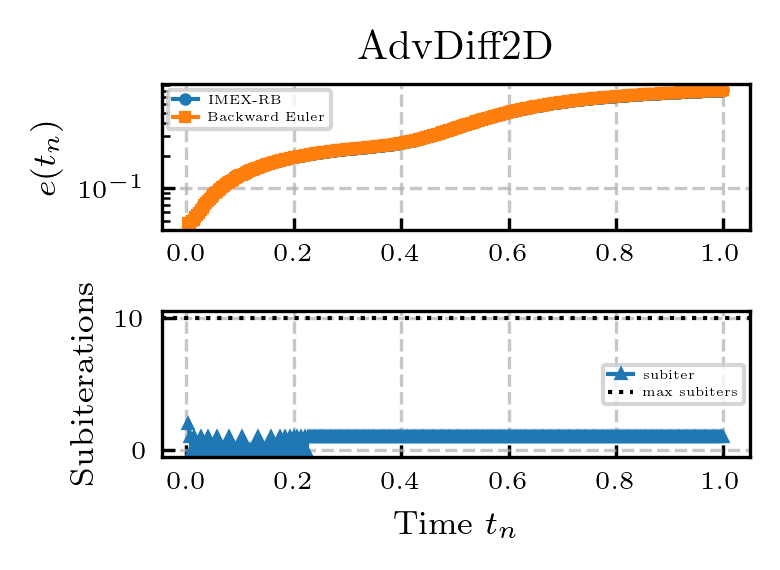

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem.coords, problem.exact_solution, dim=2)
errBE = compute_errors(uBE, tvec, problem.coords, problem.exact_solution, dim=2)
errFE = compute_errors(uFE, tvecFE, problem.coords, problem.exact_solution, dim=2)

# Plot the errors
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='s')
# plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

# Add labels, legend, and title
plt.ylabel(r"$e(t_n)$")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(tvec[1:], subiter, label="subiter", marker="^")
plt.xlabel(r"Time $t_n$")
plt.ylabel(r"Subiterations")
plt.axhline(maxsubiter, linestyle=":", color="k", label=r"max subiters")
plt.legend()

# Show the plot
plt.show()

### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

In [ ]:
plot_animation = 1
if plot_animation:

    %matplotlib ipympl
    from IPython import display
    import time
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    X, Y = problem.coords
    Nx, Ny = problem.shape
    
    zmin = min(uIMEX.min(), uBE.min())
    zmax = max(uIMEX.max(), uBE.max())

    # Setup figure with two 3D subplots
    fig = plt.figure()
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    hdisplay = display.display("", display_id=True)

    # Common formatting
    for ax, title in [(ax1, "IMEX-RB"), (ax2, "BE")]:
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$u$")
        ax.set_zlim(zmin, zmax)
        ax.set_title(title)

    # Initialize empty surfaces
    surf1 = ax1.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="viridis", alpha=0.8)
    surf2 = ax2.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)

    # Time‐loop
    for n, t in enumerate(tvec[::5]):
        # remove old surfaces
        surf1.remove()
        surf2.remove()

        # reshape solution vectors
        Z1 = uIMEX[:, n].reshape((Nx, Ny))
        Z2 = uBE[:,   n].reshape((Nx, Ny))
        Z1 = Z2
        # re‐plot
        surf1 = ax1.plot_surface(X, Y, Z1, cmap="viridis", alpha=0.8)
        surf2 = ax2.plot_surface(X, Y, Z2, cmap="plasma", alpha=0.8)

        # update display
        hdisplay.update(fig)
        # time.sleep(0.001)

    plt.close(fig)



Go back to `matplotlib inline` (after animation)

In [11]:
plt.close('all')
from IPython.display import clear_output
clear_output(wait=True)
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

In [12]:
# We now run a convergence test and plot the results
# Define the range of Nt values
Nt_values = [2**n for n in range(2, 10)]
errors_imex = []
errors_be = []
# errors_fe = []

Nt_FE_stable = compute_steps_stability_FE(problem, tspan)
# Loop over Nt values
for Nt in Nt_values:
    print(f"Running simulation for Nt = {Nt}")
    # Time discretization
    tvec = np.linspace(t0, tf, Nt + 1)
    dt = tvec[1] - tvec[0]

    # Solve the problem with each scheme
    uIMEX, *_ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    uBE, *_ = backward_euler(problem, u0, tspan, Nt)
    # uFE, *_ = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time for each scheme
    err_imex = compute_errors(uIMEX, tvec, problem.coords, problem.exact_solution, dim=2, finaltimeonly=True)
    err_be = compute_errors(uBE, tvec, problem.coords, problem.exact_solution, dim=2, finaltimeonly=True)
    # err_fe = compute_errors(uFE, tvec, problem.coords, problem.exact_solution, dim=2)

    # Store the final error
    errors_imex.append(err_imex[-1])
    errors_be.append(err_be[-1])
    # errors_fe.append(err_fe[-1])



Running simulation for Nt = 4
Stability condition NOT met (times/total): 4/4
Running simulation for Nt = 8
Stability condition NOT met (times/total): 8/8
Running simulation for Nt = 16
Stability condition NOT met (times/total): 16/16
Running simulation for Nt = 32
Stability condition NOT met (times/total): 1/32
Running simulation for Nt = 64
Stability condition NOT met (times/total): 0/64
Running simulation for Nt = 128
Stability condition NOT met (times/total): 0/128
Running simulation for Nt = 256
Stability condition NOT met (times/total): 0/256
Running simulation for Nt = 512
Stability condition NOT met (times/total): 0/512


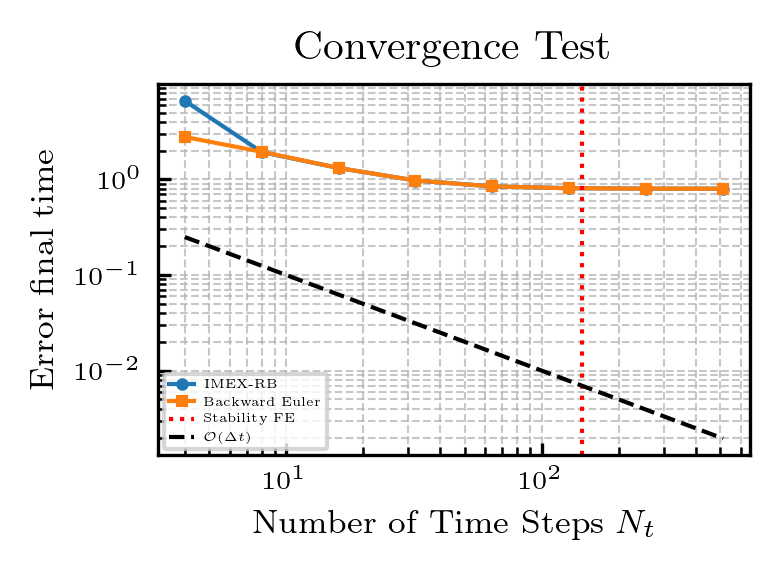

In [13]:
# Plot the convergence results
plt.loglog(Nt_values, errors_imex, label="IMEX-RB", marker='o', linestyle='-')
plt.loglog(Nt_values, errors_be, label="Backward Euler", marker='s', linestyle='-')
# plt.loglog(Nt_values, errors_fe, label="Forward Euler", marker='^', linestyle='-.')
plt.axvline(Nt_FE_stable, label="Stability FE", color="r", linestyle=':') 
plt.loglog(Nt_values, [1/Nt for Nt in Nt_values], label=r"$\mathcal{O}(\Delta t)$", color="k", linestyle='--')
plt.xlabel(r"Number of Time Steps $N_t$")
plt.ylabel("Error final time")
plt.title("Convergence Test")
plt.legend()
plt.grid(True, which="both", linewidth=0.5)
plt.show()

### CPU Time to solution

We now compare the times required by IMEX-RB and BE to obtain a stable solution
N.W.: While we will keep $N_t$ fixed for IMEX-RB and BE, we will compute the $N_t$ making FE stable at each different problem size

In [13]:
# Parameters for the simulation
print("Here some overflow error will be likely thrown by unstable FE")
kappa = 1.0
tspan = [0.0, 1.0]
Nt = 200  # Number of time steps for IMEX and BE

# Lists to store CPU times and errors
Nh_list = []
CPU_IMEX_list = []
CPU_BE_list = []
CPU_BEnogmres_list = []
CPU_FE_list = []
CPU_FEunstable_list = []

err_IMEX_list = []
err_BE_list = []
err_FE_list = []

# Loop over different spatial resolutions
Nx_values = [2**val for val in range(4, 9)]
for Nx in Nx_values:
    # Define the problem object
    Ny = Nx
    problem = AdvDiff2D(Nx, Ny, Lx, Ly, kappa, vx, vy)
    print(f"Running simulation for Nh = {problem.Nh}")
    Nh_list.append(problem.Nh)

    u0 = problem.initial_condition()
    epsilon = 1e-3  # tolerance parameter
    maxsize = int(np.ceil(np.power(Nx, 1/3)))
    maxsubiter = maxsize

    # Run IMEX-RB integration
    uIMEX, tvec, subiter, CPUtimeIMEX = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    # Run Backward Euler integration
    uBE, _, CPUTimeBE = backward_euler(problem, u0, tspan, Nt)
    *_, CPUTimeBEnogmres = backward_euler(problem, u0, tspan, Nt, gmres=False)
    # Run Forward Euler integration on its own stable time grid
    Nt_FE = compute_steps_stability_FE(problem, tspan)
    uFE, tvec_FE, CPUTimeFE = forward_euler(problem, u0, tspan, Nt_FE)
    # Run also an unstable FE for lower ideal bound on CPU time
    *_, CPUTimeFEunstable = forward_euler(problem, u0, tspan, Nt)


    # Compute errors at final time
    err_IMEX = compute_errors(uIMEX, tvec, problem.coords, problem.exact_solution, dim=2, finaltimeonly=True)
    err_BE = compute_errors(uBE, tvec, problem.coords, problem.exact_solution, dim=2, finaltimeonly=True)
    err_FE = compute_errors(uFE, tvec_FE, problem.coords, problem.exact_solution, dim=2, finaltimeonly=True)

    # Append CPU times and errors
    CPU_IMEX_list.append(CPUtimeIMEX)
    CPU_BE_list.append(CPUTimeBE)
    CPU_FE_list.append(CPUTimeFE)
    CPU_FEunstable_list.append(CPUTimeFEunstable)
    CPU_BEnogmres_list.append(CPUTimeBEnogmres)

    err_IMEX_list.append(err_IMEX)
    err_BE_list.append(err_BE)
    err_FE_list.append(err_FE)


Here some overflow error will be likely thrown by unstable FE
Running simulation for Nh = 256
Stability condition NOT met (times/total): 4/200
Running simulation for Nh = 1024
Stability condition NOT met (times/total): 73/200
Running simulation for Nh = 4096
Stability condition NOT met (times/total): 200/200


KeyboardInterrupt: 

In [ ]:

import pickle

# Save all data for CPU time plot to file
data_to_save = {
    "problem_name": problem_name,
    "Nh_list": Nh_list,
    "CPU_IMEX_list": CPU_IMEX_list,
    "CPU_BE_list": CPU_BE_list,
    "CPU_FE_list": CPU_FE_list,
    "CPU_FEunstable_list": CPU_FEunstable_list,
    "CPU_BEnogmres_list": CPU_BEnogmres_list,
    "err_IMEX_list": err_IMEX_list,
    "err_BE_list": err_BE_list,
    "err_FE_list": err_FE_list,
    "tvec": tvec,
    "tvecFE": tvecFE
}

save_file = os.path.join(results_path, "CPUtime.pkl")

with open(save_file, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"Plot data saved to {save_file}")

Plot data saved to results/AdvDiff2D/CPUtime.pkl


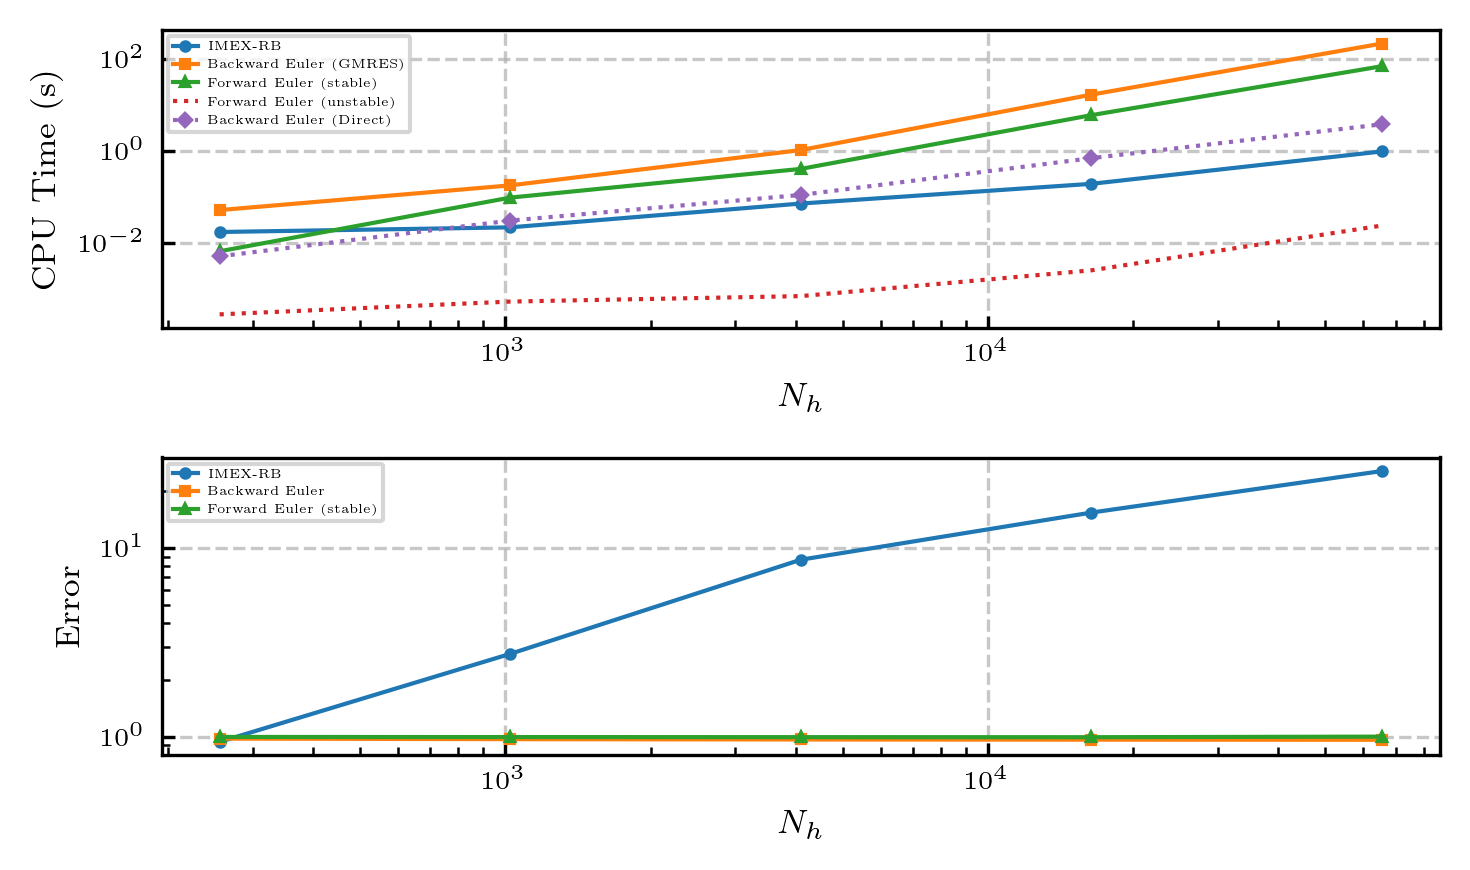

In [17]:
# Plotting CPU times vs Nx
plt.figure(figsize=(5,3))
plt.subplot(2, 1, 1)
Nh_array = np.array(Nh_list)
plt.loglog(Nh_array, CPU_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_array, CPU_BE_list, 's-', label='Backward Euler (GMRES)')

plt.loglog(Nh_array, CPU_FE_list, '^-', label='Forward Euler (stable)')
plt.loglog(Nh_array, CPU_FEunstable_list, ':', label='Forward Euler (unstable)')
plt.loglog(Nh_array, CPU_BEnogmres_list, 'D:', label='Backward Euler (Direct)')
# plt.loglog(Nh_array, 0.01 * Nh_array, ':', color='k# ', label=r'$\mathcal{O}(N_h)$')
# plt.loglog(Nh_array, 1e-4 * Nh_array**2, '--', color='k', label=r'$\mathcal{O}(N_h^2)$')
# plt.loglog(Nh_array, 1e-8 * Nh_array**3, 'D:', color='k', label=r'$\mathcal{O}(N_h^3)$')
plt.xlabel(r'$N_h$')
plt.ylabel('CPU Time (s)')
# plt.title('CPU Time vs Spatial Resolution')
plt.legend()
plt.grid(True)

# Plotting errors at final time vs Nx
plt.subplot(2, 1, 2)
plt.loglog(Nh_array, err_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_array, err_BE_list, 's-', label='Backward Euler')
plt.loglog(Nh_array, err_FE_list, '^-', label='Forward Euler (stable)')
plt.xlabel(r'$N_h$')
plt.ylabel(r'Error')
# plt.title('Error vs num of unknowns')
plt.legend()
plt.grid(True)

# plt.tight_layout()
plt.savefig(os.path.join(results_path, "CPUTime.pdf"))
plt.show()
